In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
date = "16_03_2023"
fly = "EPG_GCaMP_EL_jRGECO_fly2"
session = "open_loop_baseline-001"
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=2)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [3]:
f = h5py.File(h5name)
data = f['/data'][:]



In [4]:
data.shape

(2, 5517, 9, 206, 285)

In [5]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)


In [6]:
shifts.shape

(2, 5517, 9)

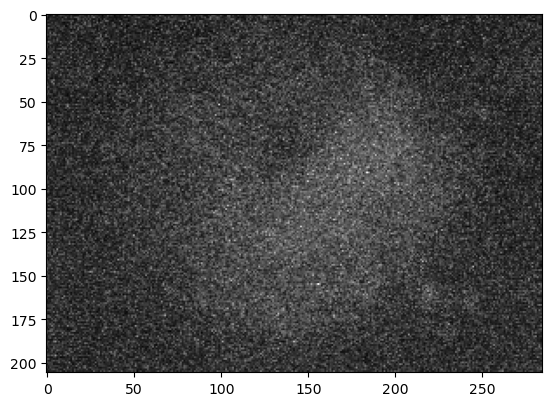

In [7]:
fig, ax = plt.subplots()
ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')

In [8]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, ref_img)


In [9]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(ref_img)

In [10]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [11]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']

In [11]:

eb_napari.make_phase_masks()
masks = eb_napari.masks

In [12]:

eb_napari.save_layers(napari_outputs_file)

In [38]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [13]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [14]:
df.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

In [15]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [16]:
df_aligned.head()

,Time(ms),Start Trigger,Opto Trigger,FicTrac Cam Exp.,FicTrac Frame Proc.,Heading,Y/Index,Arena DAC1,Arena DAC2,Heading_cartx,Heading_carty,Y/Index_cartx,Y/Index_carty,Arena DAC1_cartx,Arena DAC1_carty,Arena DAC2_cartx,Arena DAC2_carty
0,67.97441,1.0,0.0,1.0,32.0,-1.869570,0.004027,-1.837010,-3.089313,-0.294348,-0.955698,0.999992,0.004027,-0.263080,-0.964773,-0.998633,-0.052255
1,203.92323,0.0,0.0,0.0,64.0,-2.098424,0.004089,-2.097955,-3.088201,-0.503485,-0.864004,0.999992,0.004089,-0.503079,-0.864239,-0.998574,-0.053366
2,339.87205,0.0,0.0,0.0,64.0,-2.680592,0.004489,-2.624302,-3.090708,-0.895608,-0.444844,0.999990,0.004489,-0.869162,-0.494527,-0.998705,-0.050863
3,475.82087,0.0,0.0,0.0,64.0,3.001650,0.004410,3.004993,-3.089529,-0.990224,0.139486,0.999990,0.004410,-0.990685,0.136175,-0.998645,-0.052040
4,611.76969,0.0,0.0,0.0,64.0,2.637569,0.004033,2.612447,-3.089749,-0.875646,0.482952,0.999992,0.004033,-0.863236,0.504795,-0.998654,-0.051820


In [17]:
print(masks.shape)

(9, 206, 285)


In [18]:
F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [19]:
# baseline
F_base = np.copy(F)
# smooth with a 1s gaussian
F_base = sp.ndimage.gaussian_filter1d(F_base,100,axis=-1)
F_base = np.percentile(F_base,10,axis=-1, keepdims=True)
# 10 s min max
# F_base = sp.ndimage.minimum_filter1d(F_base, 300, axis=-1)
# F_base = sp.ndimage.maximum_filter1d(F_base, 300, axis=-1)

In [20]:
print(F.shape)
print(notF.shape)

(2, 16, 5517)
(2, 5517)


In [21]:
data_corr.shape
notF = sp.ndimage.gaussian_filter1d(notF,3,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,3,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,.5,axis=1, mode='wrap')
# print(whole_frame_ts.shape)


In [22]:

# denom = F[0,:,:].mean(axis=1, keepdims=True).sum(axis=0,keepdims=True)
# f_denom = F[0,:,:].mean(axis=1,keepdims=True)/denom
# dff = F[1,:,:]/F_base[1,:,:]
# dff = sp.stats.zscore(dff,axis=-1)
# dff = 0*F[1,:,:]
# dff = sp.stats.zscore(F[0,:,:]-.*F[0,:,:].mean(axis=0,keepdims=True)-.0*whole_frame_ts[np.newaxis,:],axis=-1)
dff = sp.stats.zscore(F[0,:,:]-notF[0,np.newaxis,:],axis=-1)
dff_r = sp.stats.zscore(F[1,:,:]-notF[1,np.newaxis,:],axis=-1)
# dff = sp.stats.zscore(F[0,:,:]-.7*whole_frame_ts[np.newaxis,:],axis=-1)


In [23]:
print(np.amin(dff),np.amax(dff))
print(np.amin(dff_r),np.amax(dff_r))

-3.4683539310654012 4.601080494344166
-2.988094079885752 4.08134710026173


In [24]:

x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
x_f_r,y_f_r = st2p.utilities.pol2cart(dff_r,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])


_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))


rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

rho_r,phi_r = st2p.utilities.cart2pol(x_f_r.mean(axis=0), y_f_r.mean(axis=0))
_,offset_r = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r-heading))


In [25]:
fig_folder = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/figs'
os.makedirs(fig_folder, exist_ok=True)

In [26]:
for ind in np.argwhere(df_aligned[' Opto Trigger'].to_numpy()>0).tolist():
    print(ind)
    dff[:,ind[0]:ind[0]+20]=np.nan

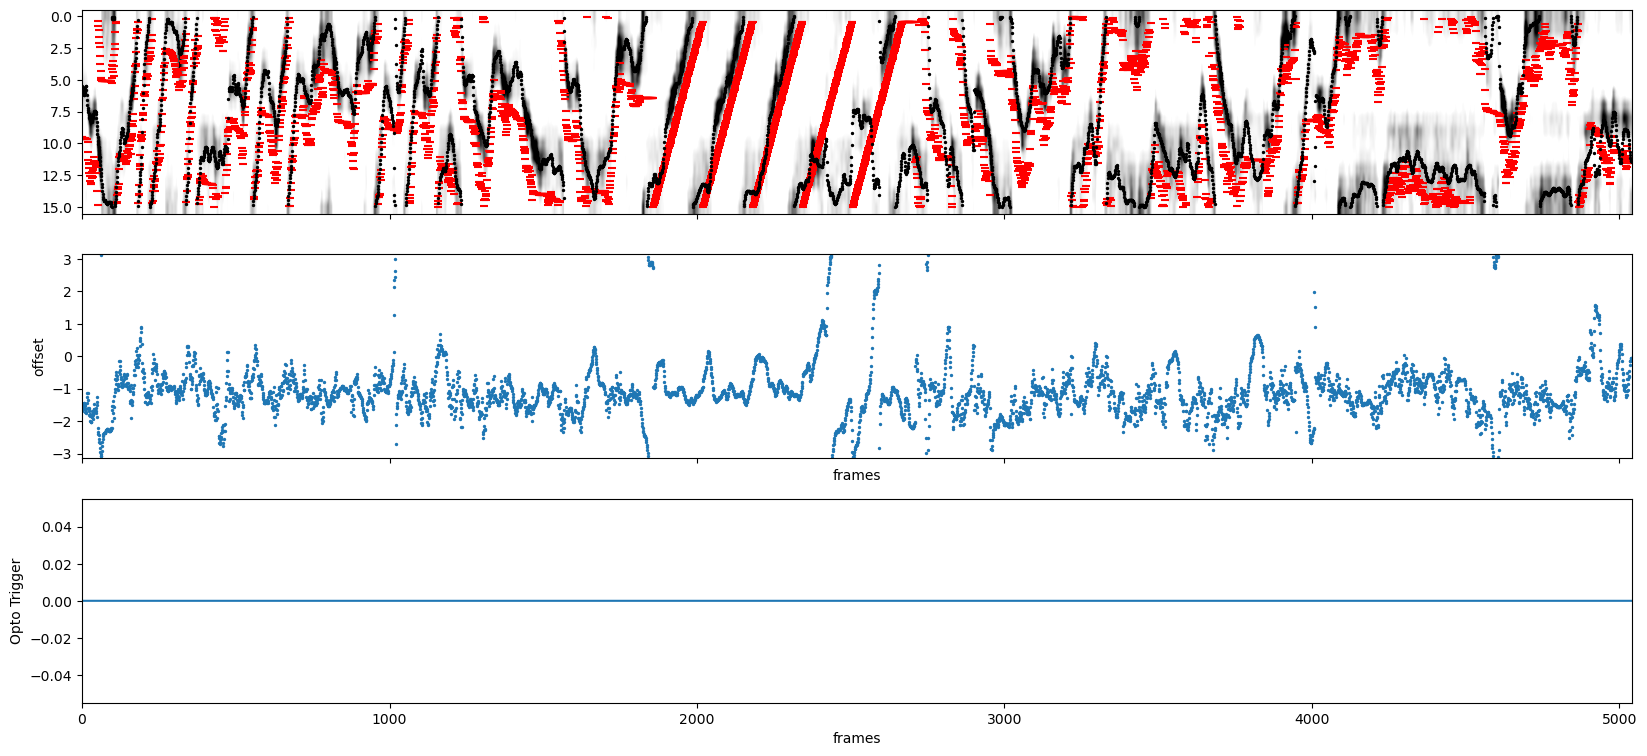

In [29]:
win_size = 6000

for num_fig, start_i in enumerate(range(0,dff.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(3,1,figsize=[20,9], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Greys',vmin=-2,vmax=3)
    x = np.arange(stop_i-start_i)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='_')
    
    ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)
    
    
    
    ax[1].scatter(x,offset[window],s=2)
    ax[1].set_ylim([-3.14,3.14])
    # ax[1].plot(x,0*offset[window], marker='_')
    ax[1].set_ylabel('offset')
    ax[1].set_xlabel('frames')
    
    ax[2].plot(x,df_aligned[' Opto Trigger'].iloc[window])
    ax[2].set_ylabel('Opto Trigger')
    ax[2].set_xlabel('frames')
    
    
    fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))


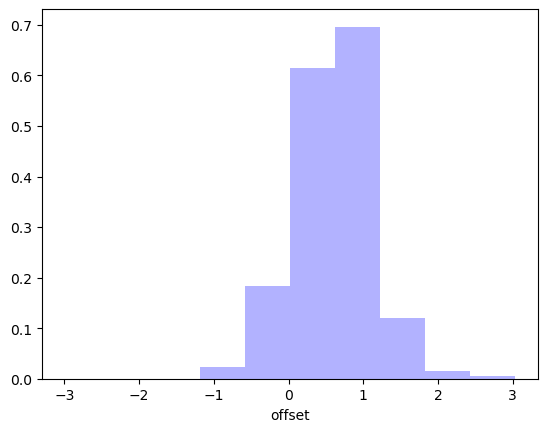

In [29]:
fig,ax = plt.subplots()
ax.hist(offset,alpha=.3, color='blue',density=True)
ax.set_xlabel('offset')
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

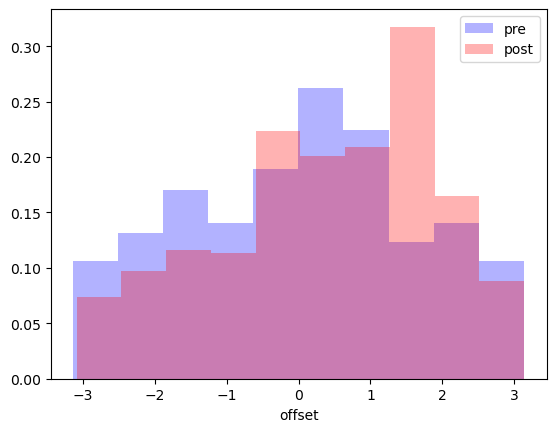

In [61]:
fig,ax = plt.subplots()
ax.hist(offset[:1200],alpha=.3, color='blue',density=True, label = 'pre')
ax.hist(offset[1600:],alpha=.3, color='red', density=True, label = 'post')
ax.set_xlabel('offset')
ax.legend()
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

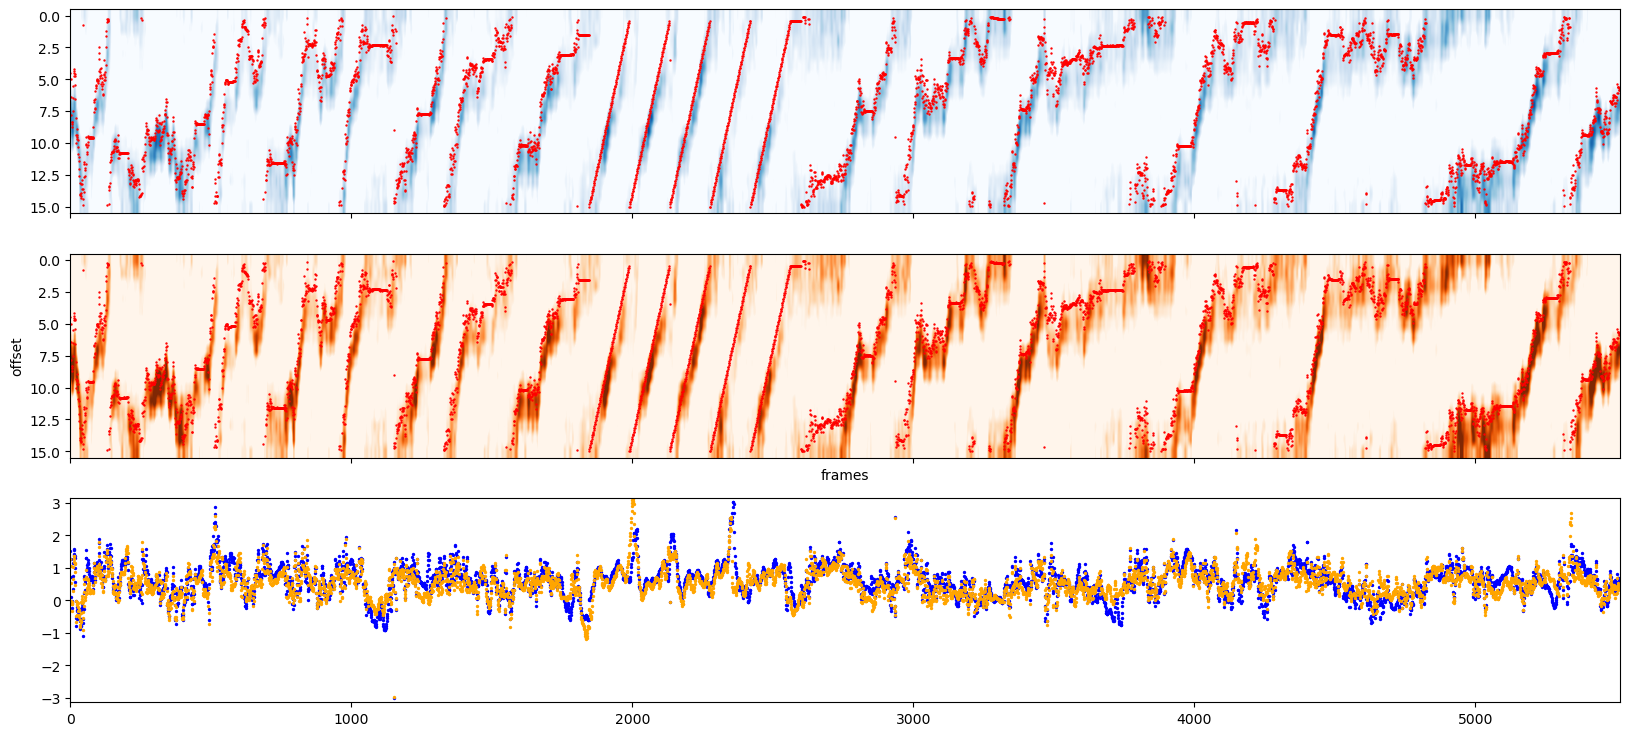

In [37]:
win_size = 6000

for num_fig, start_i in enumerate(range(0,dff.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(3,1,figsize=[20,9], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Blues',vmin=0,vmax=5)
    x = np.arange(stop_i-start_i)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    # ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)
    
    ax[1].imshow(dff_window,aspect='auto',cmap='Oranges',vmin=0,vmax=3)
    ax[1].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    # ax[1].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)
    
    
    
    ax[2].scatter(x,offset[window],s=2, color='blue')
    ax[2].scatter(x,offset_r[window],s=2, color='orange')
    ax[2].set_ylim([-3.14,3.14])
    # ax[1].plot(x,0*offset[window], marker='_')
    ax[1].set_ylabel('offset')
    ax[1].set_xlabel('frames')
    
    
    
    
    fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))

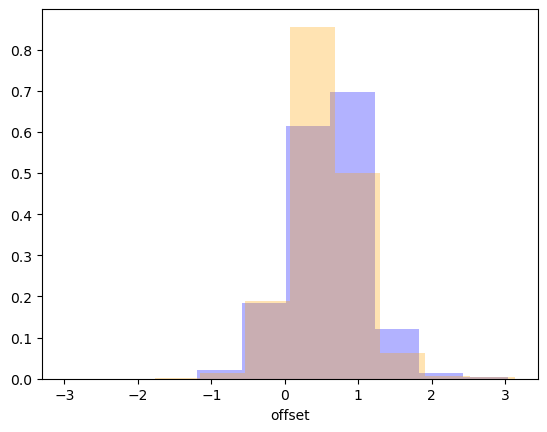

In [34]:
fig,ax = plt.subplots()
ax.hist(offset,alpha=.3, color='blue',density=True)
ax.hist(offset_r,alpha=.3, color='orange',density=True)
ax.set_xlabel('offset')
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

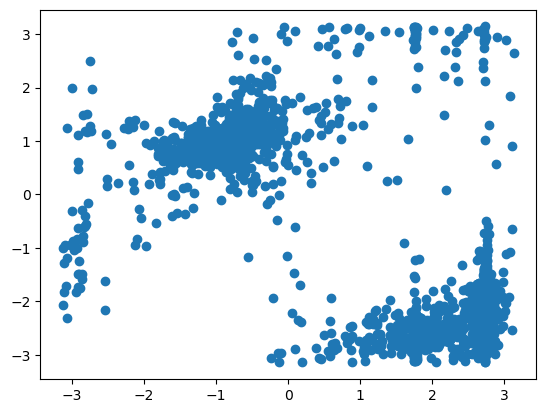

In [127]:
fig, ax = plt.subplots()
ax.scatter(heading[1600:-3],phi[1603:])


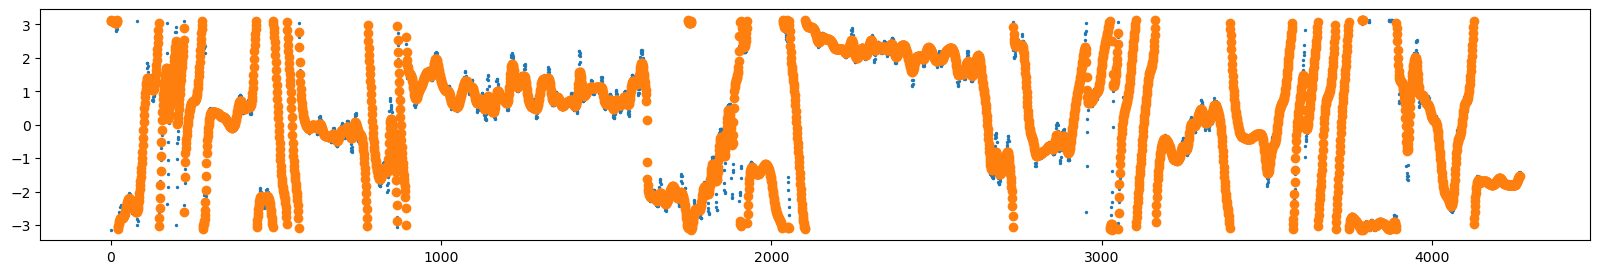

In [44]:
fig,ax = plt.subplots(figsize=[20,3])
ax.scatter(np.arange(offset.shape[0]),offset,s=2)
offset_cart_x, offset_cart_y = st2p.utilities.pol2cart(np.ones(offset.shape),offset)
_, offset_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(offset_cart_x,5),sp.ndimage.gaussian_filter1d(offset_cart_y,5))
ax.scatter(np.arange(offset.shape[0]), offset_sm)

(array([196., 162., 206., 278., 190., 186., 233., 323., 304., 478., 405.,
        320., 210., 404., 201., 170.]),
 array([-3.14068899e+00, -2.74813816e+00, -2.35558733e+00, -1.96303650e+00,
        -1.57048567e+00, -1.17793484e+00, -7.85384013e-01, -3.92833183e-01,
        -2.82353929e-04,  3.92268475e-01,  7.84819305e-01,  1.17737013e+00,
         1.56992096e+00,  1.96247179e+00,  2.35502262e+00,  2.74757345e+00,
         3.14012428e+00]),
 <BarContainer object of 16 artists>)

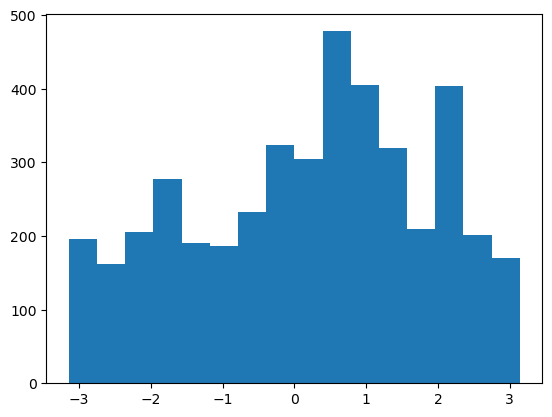

In [45]:
fig, ax = plt.subplots()
ax.hist(offset,bins=16)

In [11]:
data.shape

(2, 3280, 7, 208, 259)